# Learning item embeddings with Gensim's Word2Vec

Embeddings have become a staple in modern machine learning. Say something else smart about embeddings. 

A good embedding will provide a numerical representation for objects in a latent space, in which vectors for similar objects are physically closer to each other in that space. Word embeddings are an obvious and wildly popular application of a successful vector embedding, but there are many other applications such as product embeddings, user embeddings, graph node embeddings, etc.  Essentially, any collection of entities can be "embedded." Embedding vectors are themselves rarely the end goal. Instead, success is usually measured by metrics on some downstream task such as classification, topic assignment, clustering, or even providing relevant recommendations. 

There are myriad techniques for learning embeddings, many of which are developed with a specific type of embedding in mind (for example, collaboritive filtering can generate embeddings for users and products ideal for recommendation systeams). But sometimes, a generic approach to learning embeddings is good enough. 

In this notebook we explore one way to learn item embeddings in the context of a recommendation system using a classic embedding algorithm: Word2Vec. Details on our approach can be found in our recent research report [Session Based Recommenders](https://session-based-recommenders.fastforwardlabs.com/). 


Our goal is to learn product embeddings for each of the products in our dataset. In our Session-based Recommenders report we accomplished this by considering a customer's _session_, that is, the products each customer purchased over time. Ideally, embeddings learned in this fashion will incorporate customer preferences and history. (An alternate method is to learn content-based embeddings, which consider only features of each product rather than a user's interaction with that product.)

## Set up notebook dependencies

In addition to the Gensim library, this notebook makes use of Ray Tune for hyperparameter optimization. These and a few other dependencies are installed and imported in the following cells. 

In [1]:
%%capture
# ^ hiding large cell output. disable for logs.
!pip install -r requirements.txt

The `recsys` library included in this repo was originally developed for the Session-Based Recommenders project and includes helper functions and utilities for data, models, and metrics. Much of the functionality in this notebook is actually contained within this small library but we show it explicitly (rather than importing it) in order to showcase and explore the functionality. However, we do still rely on some of the helper functions which we import below. 

In [1]:
import collections
import itertools
from copy import deepcopy 
from typing import List

import numpy as np
import pandas as pd

from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from ray import tune
from ray.tune.schedulers import ASHAScheduler

from recsys.data import load_ecomm, load_original_ecomm, preprocess_ecomm, train_test_split
from recsys.metrics import recall_at_k
from recsys.utils import absolute_filename

## Quick exploration of the data (products in the Online Retail dataset) 

There's an entire [notebook](https://github.com/fastforwardlabs/session_based_recommenders/blob/2dde9a7265fd3a7e3bed567cd14dd412b7a5c708/notebooks/Explore_Online_Retail_Dataset.ipynb) on this in the Session-Based Recommenders repo. Just pull some of the good bits an dput them here. 


This is a transnational data set which contains all purchase transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. 

The dataset is composed of the following columns:


* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

We obtained the Online Retail dataset from the Kaggle website found [here](https://www.kaggle.com/vijayuv/onlineretail). 
The data is open source but you will need to register on Kaggle's website before downloading. 


In [2]:
df = load_original_ecomm()

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Our goal is to learn product embeddings for each of the products in our dataset. In our Session-based Recommenders report we accomplished this by considering a customer's _session_, that is, the products each customer purchased over time. Viewed in this way, each customer's product purchases 

Below is a one such customer session (you can see their full session by removing the `head` modifier):

In [4]:
customer_groups = df.groupby("CustomerID")
pd.DataFrame(list(customer_groups)[2][1])[["InvoiceDate", "StockCode", "Description"]].head(5)

,InvoiceDate,StockCode,Description
34083,2010-12-16 19:09:00,84992,72 SWEETHEART FAIRY CAKE CASES
34084,2010-12-16 19:09:00,22951,60 CAKE CASES DOLLY GIRL DESIGN
34085,2010-12-16 19:09:00,84991,60 TEATIME FAIRY CAKE CASES
34086,2010-12-16 19:09:00,84991,60 TEATIME FAIRY CAKE CASES
34087,2010-12-16 19:09:00,21213,PACK OF 72 SKULL CAKE CASES


The `StockCode` column provides a sequence of product IDs that we will treat as a sentence. Each unique customer yields a different sentence and the collection of all customer sessions will act as our corpus. We already have functionality to reformat our original dataframe into a format palatable by Gensim. 

In [5]:
corpus = preprocess_ecomm(df)

/Users/mbeck/Projects/item-embeddings-with-gensim-word2vec/data/ecomm/OnlineRetail_sessions.pkl already exists! Please use overwrite flag.


Here's that same customer, now in a format that Gensim's word2vec model will appreciate. There are 4234 "documents" in our customer session "corpus". 

In [6]:
print(*corpus[1])

84992 22951 84991 84991 21213 21213 22616 21981 21982 21725 21211 84988 22952 22952 21977 21977 POST 21980 21985 21726 21983 21967 POST 23077 23078 23076 22437 POST 23077 23078 POST


In [7]:
len(corpus)

4234

Train test spli

In [8]:
train, test, valid = train_test_split(corpus, test_size=1000)

## Setting up training

If you take a gander at the Gensim documentation, training word2vec embeddings on your corpus is a single line of code!

In [9]:
# this automatically trains word2vec on a corpus and returns a model that contains the embeddings 
out_of_the_box_model = Word2Vec(sentences=train) 


So what more do we need? Turns out, a few things. The above line of code will train word2vec using the default hyperparameters, which have emperically been deemed appropriate for  human language. However, we are not learning embeddings for words in sentences -- we're learning item embeddings from a sequence of purchases! As such, there's no reason to believe that the default hyperparameters will be sufficient for our use case. This means we'll need to perform a hyperparameter search. 


### Ingredients for hyperparameter optimization (HPO)
While integral to the machine learning lifecycle, hyperparameter optimization is a computationally demanding task. In order to manage and minimize the computational cost, we'll need some help from the [Ray Tune](https://docs.ray.io/en/master/tune/index.html), a Python library for experiment execution and hyperparameter tuning at any scale. Specifically, we'll make use of an early stopping algorithm (ASHA) that terminates trials of hyperparameter configurations that are underperforming, thus saving compute time for configurations that are more promising. 


ASHA (and other early stopping HPO algorithms) work by monitoring a metric during training for each hyperparameter configuration, comparing them, and terminating those that underperform. This means we need a metric to monitor throughout training. The single line code snippet above will not get us there! Enter Gensim Callbacks. 


### Logging metrics during training with Gensim Callbacks

A loss logger is pretty standard but it turns out that Gensim's loss logging for the word2vec model is a little buggy and probably incorrect (see [this] GitHub issue). While it is useful for drawing general conclusions about the overall health of your training (e.g., loss should generally be decreasing), the actual values are not super useful. 

In [10]:
class LossLogger(CallbackAny2Vec):
    '''Report training loss at each epoch'''
    def __init__(self):
        self.epoch = 0
        self.previous_loss = 0
        self.training_loss = []

    def on_epoch_end(self, model):
        # the loss output by Word2Vec is more akin to a cumulative loss and increases each epoch
        # to get a value closer to loss per epoch, we subtract
        cumulative_loss = model.get_latest_training_loss()
        loss = cumulative_loss - self.previous_loss
        self.previous_loss = cumulative_loss
        self.training_loss.append(loss)
        print(f' Loss: {loss}')
        self.epoch += 1

More importantly, monitoring the model's training loss doesn't really tell us much about the quality of our item embeddings. For that, we need to consider a metric that measures a downstream task we're interested in. For example, since we're trying to learn item embeddings, we might be interested in how successful these embeddings are at providing recommendations. There are tons of metrics that measure recommendation quality. We'll use Recall@K. 

This callback is more advanced than simply reporting the model's internal training loss. The training loss is an attribute of the model itself. As such, it's easy to call as shown above on line 11.  By contrast, downstream metrics evaluate the quality of the embeddings so they are computed using the model's learned embeddings _up to that point in the training,_ as applied to a validation set.  This requires a bit of finaggling (see lines 17 and 18). 

In [11]:
class RecallAtKLogger(CallbackAny2Vec):
    '''Report Recall@K at each epoch
    
    Computes and reports recall_at_k metric for a given validation_set and k value. 
    recall_at_k metric is implemented in the recsys library. See there for more details.
    
    Inputs:
        validation_set   : 
        k                : the "K" in recall_at_k (number of recommendations to generate)
        ray_tune         : if true, reports recall_at_k to Ray; else to STDOUT
        save_model       : if true, saves model to disk every 10 epochs
    '''
    def __init__(self, validation_set:List[List[str]], k:int, 
                 ray_tune:bool = False, save_model:bool = False):
        self.epoch = 0
        self.recall_scores = []
        self.validation = validation_set
        self.k = k
        self.tune = ray_tune
        self.save = save_model

    def on_epoch_begin(self, model):
        if not self.tune:
            print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        # must deepcopy the model and set the copy's wv to None
        mod = deepcopy(model)
        mod.wv.norms = None # will cause it recalculate norms 
        
        # Checkpoint: save the model every 10 epochs
        if self.epoch%10 == 0 and self.save: 
            model.save(absolute_filename(f"{MODEL_DIR}w2v_{self.epoch}.model"))
        
        ratk_score = recall_at_k(self.validation, mod.wv, self.k)  

        if self.tune: 
            tune.report(recall_at_k = ratk_score)    
        else:
            self.recall_scores.append(ratk_score)
            print(f' Recall@10: {ratk_score}')
        self.epoch += 1

Now we can create a wrapper to train our word2vec model. We'll allow it to be trained with or without the Callbacks above (to provide additional flexibility). After training, this function returns the all-important embeddings vectors. 

In [12]:
def train_w2v(train_data:List[List[str]], params:dict, callbacks=None):
    """ training wrapper for word2vec
    
    Inputs
        train_data  : List of Lists
        params      : hyperparameters
        callbacks   : (List) callbacks to associate with the model
    """
    if callbacks:
        model = Word2Vec(callbacks=callbacks, **params)
    else:
        model = Word2Vec(**params)
    model.build_vocab(train_data)
    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
    vectors = model.wv
    return vectors

Ray Tune requires a wrapper of it's own to execute for each hyperparameter configuration it attempts. This wrapper should contain everything necessary to train and evaluate the model: 
* data loading
* metric logging
* model training

In [13]:
def tune_w2v(hyperparameters:dict):
    """ Hyperparameter optimization wrapper for Ray Tune"""
    ratk_logger = RecallAtKLogger(valid, k=10, ray_tune=True)
    train_w2v(train, params=hyperparameters, callbacks=[ratk_logger])

## Hyperperamter optimization and early stopping with Ray Tune

Now we come to the good stuff! Here we define the hyperparameter search space. The Word2Vec model has many tunable hyperparameters. We select a subset here and perform a grid search. We also define a trial scheduler which will terminate trials with underperforming hyperparameter configurations. 

Note that grid search is not a 

In [35]:
search_space = {
    "size":         tune.randint(10, 100),
    "window":       tune.randint(3, 25),
    "ns_exponent":  tune.quniform(-1.0, 1.0, .2),
    "alpha":        tune.loguniform(1e-4, 1e-2),
    "negative":     tune.randint(1, 25),
    "iter": 50,     # number of epochs
    "min_count": 1, # number of instances that a token appears before word2vec creates an embedding vector for it
    "workers": 6,   # number of CPU workers
    "sg": 1,        # trains the skip-gram version of word2vec
}

asha_scheduler = ASHAScheduler(max_t=100, grace_period=10) 

analysis = tune.run(
    tune_w2v,
    local_dir=absolute_filename("ray_results"), # HPO trial results saved in this directory
    metric="recall_at_k",
    mode="max",
    scheduler=asha_scheduler,
    verbose=1,
    resources_per_trial={
        "cpu": 1,
        "gpu": 0
    },
    num_samples=10,       # number of HP trials to attempt
    config=search_space,
)

2021-07-14 15:48:50,400	INFO tune.py:450 -- Total run time: 311.07 seconds (310.92 seconds for the tuning loop).


In [24]:
path = "/Users/mbeck/Projects/item-embeddings-with-gensim-word2vec/ray_results/tune_w2v_2021-07-14_15-43-39"
analysis = tune.Analysis(path, default_metric="recall_at_k", default_mode="max")

### Visualize HPO trials
Below we can examine the results of our hyperparameter optimization experiment. We plot the metric as a function of epochs for every attempted trial. Notice that many trials are terminated early because they clearly were performing worse than a few others, which dominated the metric throughout training. Only two hyperparameter configurations completed all 50 epochs of training, saving us a ton of compute time! 

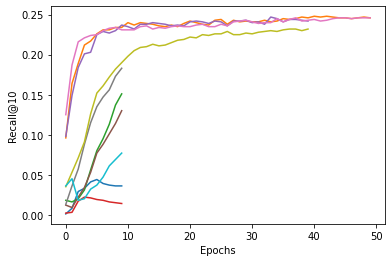

In [25]:
# Plot all trials as a function of epochs
dfs = analysis.trial_dataframes
ax = None
for d in dfs.values():
    ax = d.recall_at_k.plot(ax=ax)
ax.set_xlabel("Epochs");
ax.set_ylabel("Recall@10");


This process has produced a winning set of hyperparameters that we can now use to learn the best item embeddings for our dataset. Unless you set the `save_model = True` flag, we now need to train the winning model! (Ray Tune supports checkpointing and model saving but we have not implemented those features here). 

In [26]:
best_hps = analysis.get_best_config()
print(best_hps)

{'alpha': 0.0048761605746311, 'iter': 50, 'min_count': 1, 'negative': 3, 'ns_exponent': 0.2, 'sg': 1, 'size': 38, 'window': 9, 'workers': 6}


In [41]:
tuned_model = Word2Vec(sentences=train, **best_hps)

## Results

Our goal was to learn predictive item embeddings for the products in our catalog based on customer interactions with those products. 

In [42]:
tuned_embeddings = tuned_model.wv
ootb_embeddings = out_of_the_box_model.wv

Let's evaluate our embeddings on the test set now! We'll use the same metric we used during hyperparameter optimization. 

In [46]:
tuned_recall_at_k = recall_at_k(test, tuned_embeddings, k=10)
ootb_recall_at_k = recall_at_k(test, ootb_embeddings, k=10)

In [47]:
tuned_recall_at_k

0.237

In [48]:
ootb_recall_at_k

0.203